<a href="https://colab.research.google.com/github/RyanClothier22/Cointegrated_stock_scanner/blob/main/Cointegration_Scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 783.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 4.9 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels.tsa.stattools as ts 
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
import random
import time
import matplotlib.dates as mdates

### Initalizing Data Window

In [3]:
end = dt.date.today() - dt.timedelta(days=1)
start = end - dt.timedelta(days=365*3)

### Define Helper Functions

In [4]:
def get_data(stock, start, end):
  df = yf.download(stock, start, end)
  return df['Adj Close'], df['Volume']

In [5]:
def get_sp():
  data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  df = data[0]
  stocks = df['Symbol'].tolist()
  for i in range(len(stocks)):
    if "."  in stocks[i]:
      stocks[i] = stocks[i].replace(".", "-")
  return stocks

In [6]:
 ### Define the Cointegration tester function
def coint_test(A, B):
  if A.name != B.name:
    if pearsonr(A,B).pvalue < 0.02:
      if linregress(A,B).rvalue ** 2 > 0.9:
        if ts.coint(A,B)[1]  < 0.02:
            return [A.name, B.name]


In [7]:
# Find Cointegrated Pairs from DataFrame

def find_pairs(df):
  tickers = df.columns.tolist()
  coint_list = []
  for i in range(len(tickers)):
    for j in range(i, len(tickers)):
      entry = coint_test(df[tickers[i]],df[tickers[j]])
      if entry != None:
        coint_list.append(entry)
    
    print(f"Found {len(coint_list)} after {i+1} Stocks")

  return coint_list

In [8]:
# Make a Seires with the 100 highest volume stocks
def find_highest_volumes(volumes,df):
  means = {}
  for i in volumes.columns:
    means[i] = volumes[i].mean()
  means = pd.Series(means)
  means.sort_values(ascending=False)
  means = means[:100]
  high_volume_data = pd.DataFrame()
  for i in means.index.tolist():
    high_volume_data[i] = df[i]

In [9]:
### Returns Train split of data set
def train(X):
  return X[:int(len(X)*0.7)]

In [10]:
### Returns Test split of data set
def test(X):
  return X[int(len(X)*0.7):]

### Define Chart Functions

In [11]:
### Make a heatmap grid to show findings

In [12]:
def dual_axis_chart(A,B,ax):
  ax.set_title(f"Price overlay of {A.name} and {B.name}")
  ax2 = ax.twinx()
  ax.plot(A, color='orange')
  ax2.plot(B, color='blue')
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [13]:
def scatter_chart(A,B,ax):
  ax.scatter(train(A),train(B), color='blue')
  ax.scatter(test(A),test(B), color='orange')

  regression = linregress(A,B)
  a = regression.slope
  b=regression.intercept
  ax.plot(A, a* A + b,color='red')
  ax.set_title(f"R Squared: {round(regression.rvalue ** 2,2)}")

In [14]:
def ratio_plot(A,B,ax):
  fig = plt.figure()
  ratio = A/B
  ax.plot(train(ratio), color='blue')
  ax.plot(test(ratio), color='orange')
  ax.set_title(f"Price Ratio of {A.name} and {B.name}")
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [15]:
def zscore_plot(A, B,ax):
  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60
  ax.plot(zscore[60:], color='blue')
  ax.set_title(f"Z-Score plot of Price Ratio")
  ax.axhline(y=-0.5, color='red', linestyle='--')
  ax.axhline(y=0.5, color='red', linestyle='--', label='Buy Spread')
  ax.axhline(y=1, color='orange', label='Sell Spread')
  ax.axhline(y=-1, color='orange')
  ax.legend()
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [16]:
def buy_sell_signals(A, B, ax):
  ax.plot(A,color='blue',label=A.name)
  ax.plot(B,color='orange',label=B.name)
  ax.set_title(f"Buy and Sell Signals")

  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60


  buy = A.copy()
  sell = B.copy()
  buy[zscore>-1] = 0
  sell[zscore<1] = 0
  ax.plot(buy[60:], color='green', linestyle='None', marker='^', label='buy')
  ax.plot(sell[60:],color='red', linestyle='None', marker='^', label='sell')
  ax.set_ylim(min(A.min(), B.min()), max(A.max(), B.max()))
  ax.legend()
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


In [17]:
# Trade using a simple strategy
def trade(A, B):
  
  balance = []

  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60
    
  cash = 100
  A_shares = 0
  B_shares = 0
  for i in range(len(ratio)):
      if zscore[i] > 1:
          cash += A[i] - B[i] * ratio[i]
          A_shares -= 1
          B_shares += ratio[i]
      elif zscore[i] < -1:
          cash -= A[i] - B[i] * ratio[i]
          A_shares += 1
          B_shares -= ratio[i]
      elif abs(zscore[i]) < 0.75:
          cash += A[i] * A_shares + B[i] * B_shares
          A_shares = 0
          B_shares = 0
          
      balance.append(cash)
  return balance

In [18]:
def simulation_plot(A,B,ax):
  ax.set_title("Trade Simulation")
  ax.plot(A.index, trade(A,B))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))



In [19]:
def residual_plot(A, B, ax):
  res = A - B
  ax.set_title("Price Gap")
  ax.plot(train(res), color='blue')
  ax.plot(test(res), color = 'orange')
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [20]:
def make_subplot(A,B):
  fig, ax = plt.subplots(2,3, figsize =(15,10))
  fig.tight_layout(pad=5)

  fig.suptitle(f"{A.name} and {B.name} Cointegration Dashboard", fontsize=25, y=1.03)
  residual_plot(A,B,ax[0][0])
  ratio_plot(A,B, ax[0][1])
  scatter_chart(A,B, ax[1][0])
  zscore_plot(A,B, ax[1][1])
  buy_sell_signals(test(A),test(B), ax[0,2])
  simulation_plot(test(A),test(B), ax[1][2])


In [21]:
def summary_chart(A,B):
  fig, ax = plt.subplots(3,3, figsize =(15,15))
  fig.tight_layout(pad=5)
  fig.suptitle(f"{A.name} and {B.name} Summary plots", fontsize=25, y=1.01)
  residual_plot(A,B, ax[0][0])
  scatter_chart(A,B, ax[0][1])
  ratio_plot(A,B, ax[0][2])
  zscore_plot(train(A), train(B), ax[1][0])
  buy_sell_signals(train(A),train(B), ax[1][1])
  simulation_plot(train(A),train(B), ax[1][2])
  zscore_plot(test(A), test(B), ax[2][0])
  buy_sell_signals(test(A),test(B), ax[2][1])
  simulation_plot(test(A),test(B), ax[2][2])
  return fig

### Run Screener

In [22]:
 ### Download Adj Close and Volume Data
df, volume = get_data(get_sp(), start, end)
df = df.dropna(axis=1)
volume = volume.dropna(axis=1)

[*********************100%***********************]  503 of 503 completed


In [23]:
### Gets stock data with the 100 highest average trading volume
high_volume_data = find_highest_volumes(volume, df)

In [24]:
coint_list = find_pairs(train(df))

Found 3 after 1 Stocks
Found 3 after 2 Stocks
Found 3 after 3 Stocks
Found 6 after 4 Stocks
Found 18 after 5 Stocks
Found 19 after 6 Stocks
Found 19 after 7 Stocks
Found 30 after 8 Stocks
Found 32 after 9 Stocks
Found 37 after 10 Stocks
Found 37 after 11 Stocks
Found 38 after 12 Stocks
Found 38 after 13 Stocks
Found 38 after 14 Stocks
Found 44 after 15 Stocks
Found 51 after 16 Stocks
Found 55 after 17 Stocks
Found 61 after 18 Stocks
Found 66 after 19 Stocks
Found 68 after 20 Stocks
Found 70 after 21 Stocks
Found 84 after 22 Stocks
Found 84 after 23 Stocks
Found 94 after 24 Stocks
Found 94 after 25 Stocks
Found 100 after 26 Stocks
Found 100 after 27 Stocks
Found 101 after 28 Stocks
Found 104 after 29 Stocks
Found 107 after 30 Stocks
Found 111 after 31 Stocks
Found 111 after 32 Stocks
Found 117 after 33 Stocks
Found 118 after 34 Stocks
Found 118 after 35 Stocks
Found 118 after 36 Stocks
Found 122 after 37 Stocks
Found 127 after 38 Stocks
Found 128 after 39 Stocks
Found 137 after 40 Stock

In [25]:
### Displays how many cointegrated pairs were found
print(len(coint_list))

678


### Show Sample Charts

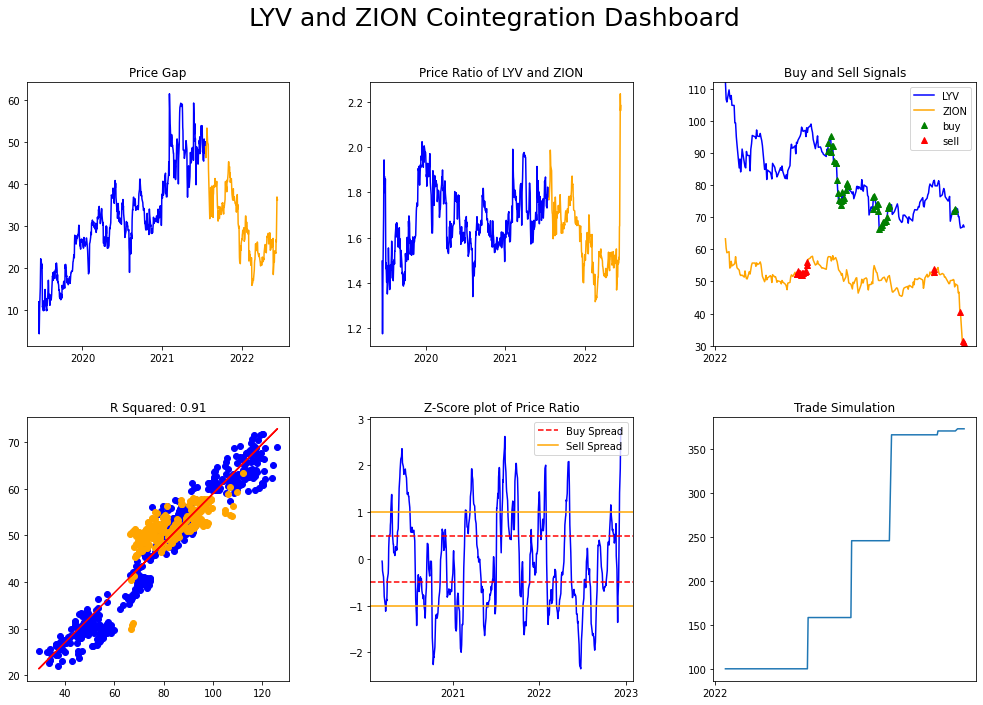

<Figure size 432x288 with 0 Axes>

In [26]:
i = random.choice(coint_list)
A, B = df[i[0]], df[i[1]]
make_subplot(A,B)

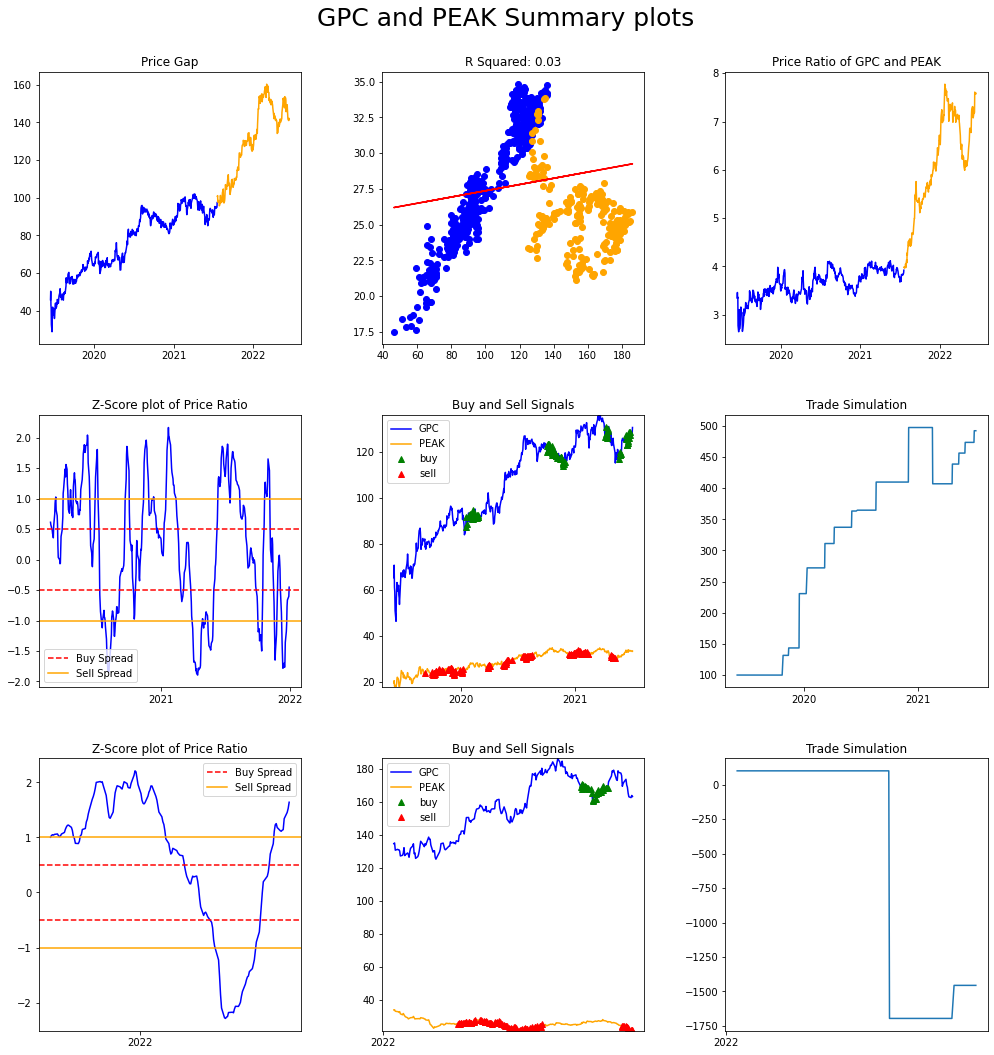

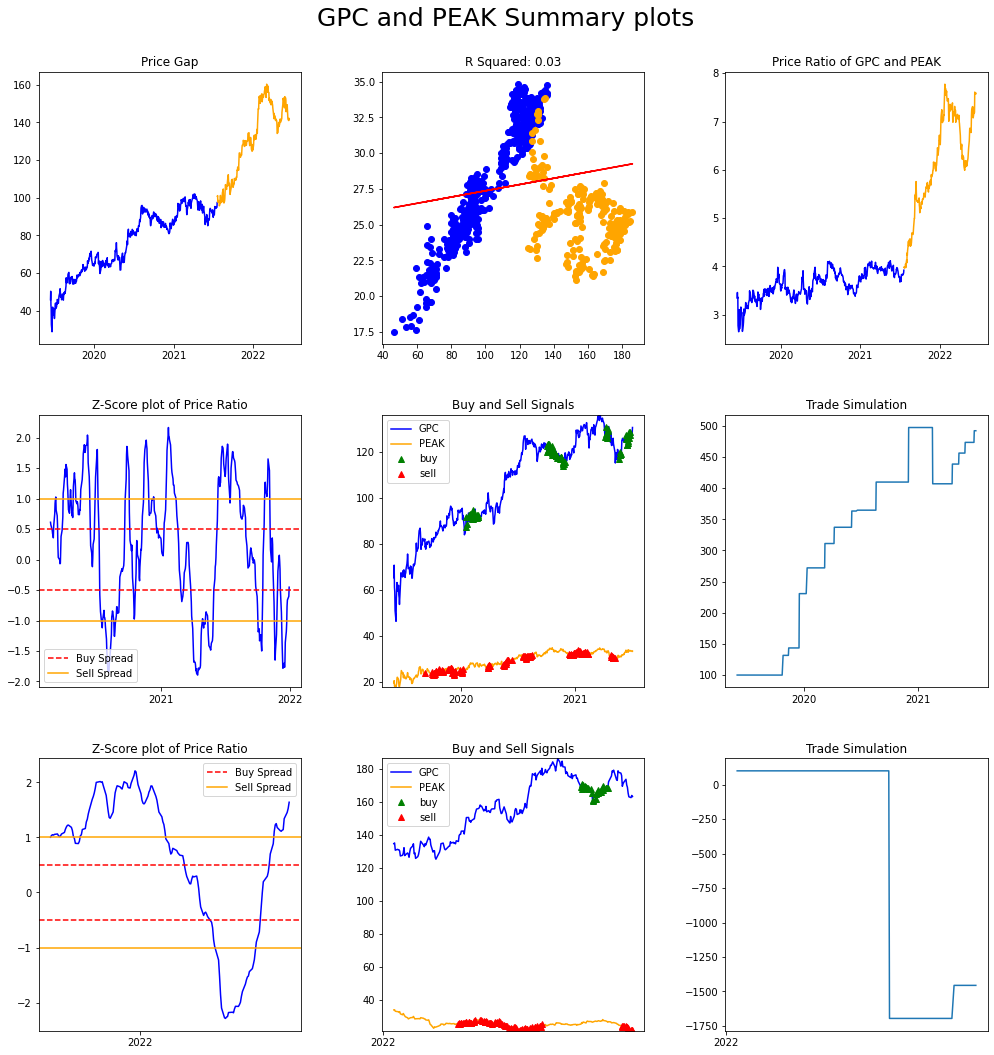

<Figure size 432x288 with 0 Axes>

In [27]:
i = random.choice(coint_list)
A, B = df[i[0]], df[i[1]]
summary_chart(A,B)

### Save Charts from List

In [28]:
!rm *

rm: cannot remove 'sample_data': Is a directory


In [ ]:
for pair in coint_list[:35]:
  A, B = df[pair[0]], df[pair[1]]
  fig = summary_chart(A,B)
  fig.savefig(f'{pair[0]} and {pair[1]} Cointegration Plot')

<ipython-input-21-c2065eb30ca5>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3,3, figsize =(15,15))


In [ ]:
!zip -r /content/file.zip /content/